In [1]:
# Install required packages
!pip install yfinance pandas numpy matplotlib scikit-learn keras tensorflow

In [2]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, Input, concatenate
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Functions for later use
def calculate_metrics(y_true, y_pred, threshold=0.5):
    """Calculate accuracy and precision for directional prediction"""
    # Convert to directional movements (1 for up, 0 for down)
    y_true_dir = np.array([1 if y_true[i] > y_true[i-1] else 0 for i in range(1, len(y_true))])
    y_pred_dir = np.array([1 if y_pred[i] > y_pred[i-1] else 0 for i in range(1, len(y_pred))])
    
    # Calculate metrics
    acc = accuracy_score(y_true_dir, y_pred_dir)
    prec = precision_score(y_true_dir, y_pred_dir, zero_division=0)
    
    return acc, prec

In [4]:
# Set date range
end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)  # Using 10 years of data

In [5]:
# Get user input for stock ticker
stock = input("Enter stock ticker (e.g., GOOG, AAPL, TSLA): ").upper()

Enter stock ticker (e.g., GOOG, AAPL, TSLA):  GOOG


In [6]:
# Download stock data
print(f"Downloading data for {stock}...")
stock_data = yf.download(stock, start, end, period="1mo")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [7]:
# Display data info
print(stock_data.info(), "\n")
print("Missing Values:\n", stock_data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2015-06-01 to 2025-05-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, GOOG)   2516 non-null   float64
 1   (High, GOOG)    2516 non-null   float64
 2   (Low, GOOG)     2516 non-null   float64
 3   (Open, GOOG)    2516 non-null   float64
 4   (Volume, GOOG)  2516 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.9 KB
None 

Missing Values:
 Price   Ticker
Close   GOOG      0
High    GOOG      0
Low     GOOG      0
Open    GOOG      0
Volume  GOOG      0
dtype: int64


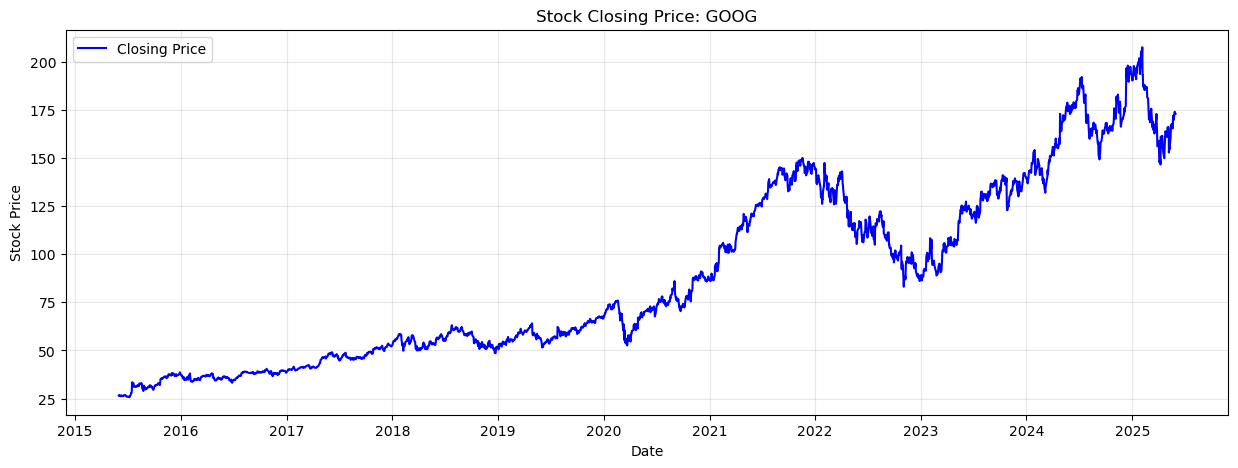

In [8]:
# Plot closing price
plt.figure(figsize=(15,5))
plt.plot(stock_data['Close'], label="Closing Price", color='blue')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"Stock Closing Price: {stock}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
# Compute moving averages
stock_data['MA_50'] = stock_data['Close'].rolling(50).mean()
stock_data['MA_200'] = stock_data['Close'].rolling(200).mean()

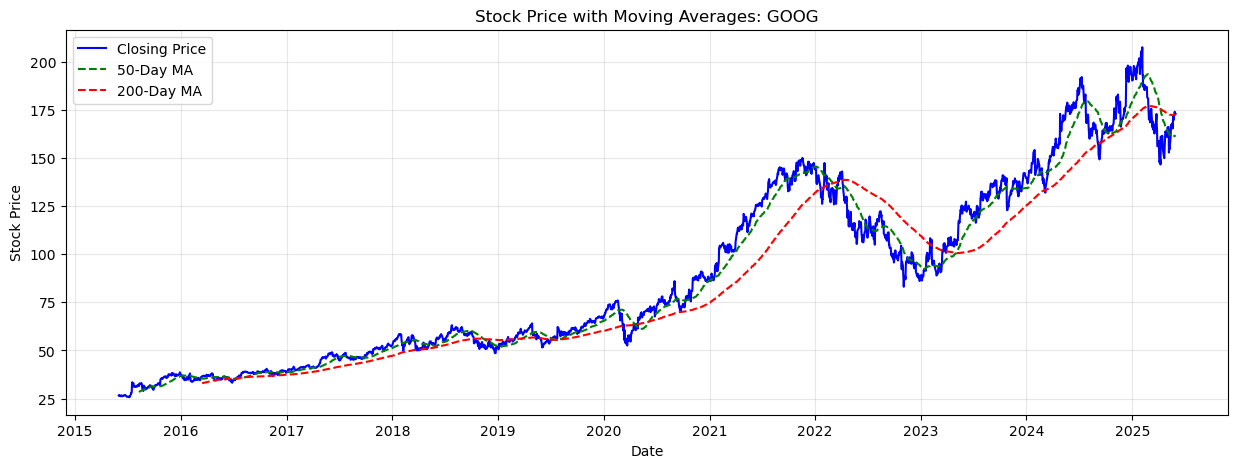

In [10]:
# Plot closing price with moving averages
plt.figure(figsize=(15,5))
plt.plot(stock_data['Close'], label="Closing Price", color='blue')
plt.plot(stock_data['MA_50'], label="50-Day MA", color='green', linestyle='dashed')
plt.plot(stock_data['MA_200'], label="200-Day MA", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"Stock Price with Moving Averages: {stock}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
# Prepare data for modeling
# Use only 'Close' prices for simplicity
data = stock_data[['Close']].copy()
data.dropna(inplace=True)

In [12]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [13]:
# Create sequences for LSTM & CNN
lookback = 60  # Using 60 days of data to predict next day
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

In [14]:
# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [15]:
# Split into train and test sets (70% train, 30% test)
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [16]:
print(f"Training Set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing Set: X_test: {X_test.shape}, y_test: {y_test.shape}")

Training Set: X_train: (1719, 60, 1), y_train: (1719,)
Testing Set: X_test: (737, 60, 1), y_test: (737,)


In [17]:
# Save dates for testing period for later use
test_dates = data.index[train_size+lookback:].tolist()

In [18]:
# -------------------------- LSTM MODEL --------------------------
# Build LSTM model
lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

In [19]:
# Compile model
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [20]:
# Display model summary
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train LSTM model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0160 - mae: 0.0821 - val_loss: 0.0018 - val_mae: 0.0345
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 8.6298e-04 - mae: 0.0193 - val_loss: 8.4515e-04 - val_mae: 0.0242
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 7.5452e-04 - mae: 0.0174 - val_loss: 0.0010 - val_mae: 0.0257
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 5.2641e-04 - mae: 0.0157 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 5.6581e-04 - mae: 0.0161 - val_loss: 9.7499e-04 - val_mae: 0.0252
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.5805e-04 - mae: 0.0141 - val_loss: 9.2497e-04 - val_mae: 0.0245
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.4198e-04 - mae: 0.0135 - val_loss: 0.0018 - val_mae: 0.0345


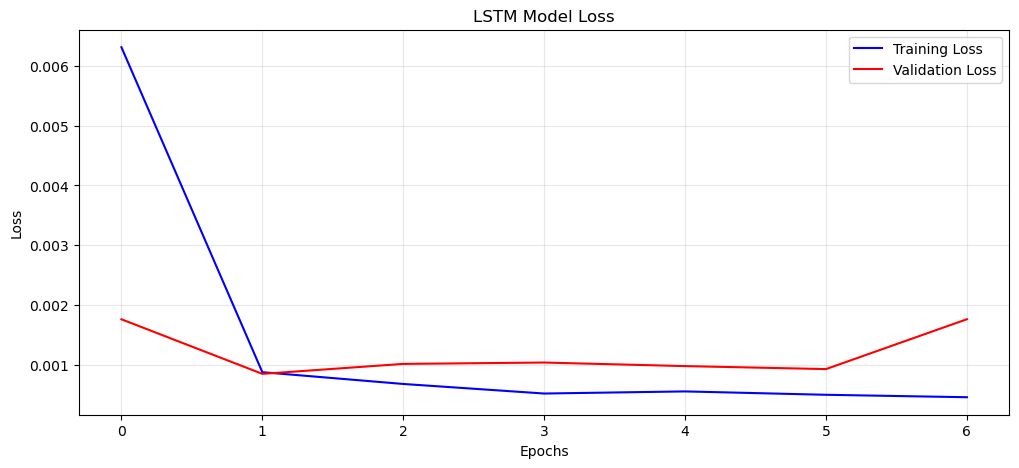

In [22]:
# Plot training history
plt.figure(figsize=(12,5))
plt.plot(history_lstm.history['loss'], label='Training Loss', color='blue')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss', color='red')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [23]:
# Generate LSTM predictions
lstm_predictions = lstm_model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [24]:
# -------------------------- CNN MODEL --------------------------
# Build CNN model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(lookback, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

In [25]:
# Compile CNN model
cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [26]:
# Display model summary
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 58, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 27, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 13, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 416)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │        20,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,333 (106.77 KB)

 Trainable params: 27,333 (106.77 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train CNN model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_cnn = cnn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0066 - mae: 0.0520 - val_loss: 0.0089 - val_mae: 0.0831
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3571e-04 - mae: 0.0158 - val_loss: 0.0109 - val_mae: 0.0952
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0512e-04 - mae: 0.0160 - val_loss: 0.0067 - val_mae: 0.0702
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9303e-04 - mae: 0.0138 - val_loss: 0.0072 - val_mae: 0.0740
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3197e-04 - mae: 0.0147 - val_loss: 0.0048 - val_mae: 0.0572
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5139e-04 - mae: 0.0129 - val_loss: 0.0026 - val_mae: 0.0404
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2263e-04 - mae: 0.0124 - val_loss: 0.0030 - val_mae: 0.0442
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2186e-04 - mae: 0.0125 - val_loss: 0.0014 - val_mae: 0.0316
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

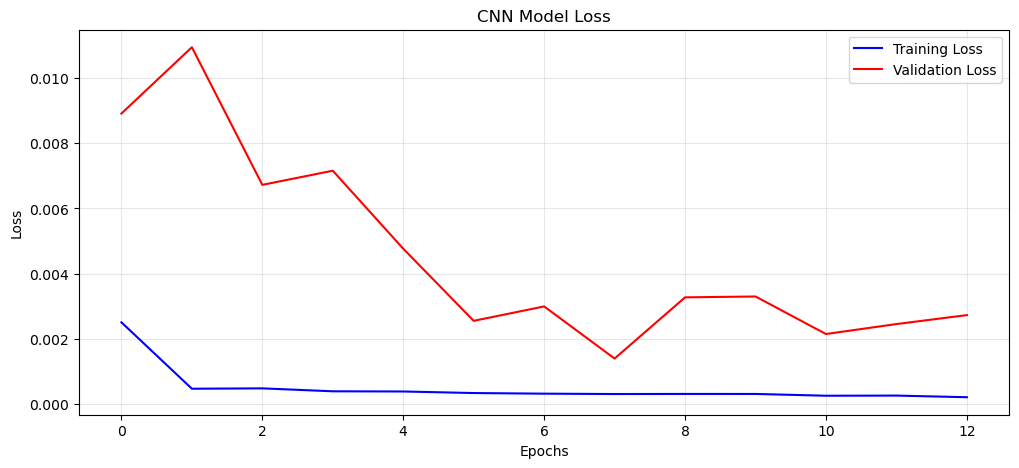

In [28]:
# Plot training history
plt.figure(figsize=(12,5))
plt.plot(history_cnn.history['loss'], label='Training Loss', color='blue')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss', color='red')
plt.title('CNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [29]:
# Generate CNN predictions
cnn_predictions = cnn_model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [30]:
# -------------------------- HYBRID CNN-LSTM MODEL --------------------------
# Build hybrid CNN-LSTM model
input_layer = Input(shape=(lookback, 1))

In [31]:
# CNN part
cnn_part = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
cnn_part = MaxPooling1D(pool_size=2)(cnn_part)
cnn_part = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn_part)

In [32]:
# LSTM part
lstm_part = LSTM(units=50, return_sequences=True)(cnn_part)
lstm_part = Dropout(0.2)(lstm_part)
lstm_part = LSTM(units=50, return_sequences=False)(lstm_part)
lstm_part = Dropout(0.2)(lstm_part)

In [33]:
# Dense layers
dense_layer = Dense(units=25)(lstm_part)
output_layer = Dense(units=1)(dense_layer)

In [34]:
# Create model
hybrid_model = Model(inputs=input_layer, outputs=output_layer)

In [35]:
# Compile model
hybrid_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [36]:
# Display model summary
hybrid_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 58, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 27, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 27, 50)         │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 27, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,533 (173.96 KB)

 Trainable params: 44,533 (173.96 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Train hybrid model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_hybrid = hybrid_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0188 - mae: 0.0925 - val_loss: 0.0015 - val_mae: 0.0327
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010 - mae: 0.0212 - val_loss: 0.0016 - val_mae: 0.0336
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.3998e-04 - mae: 0.0189 - val_loss: 0.0028 - val_mae: 0.0422
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.4546e-04 - mae: 0.0178 - val_loss: 0.0017 - val_mae: 0.0327
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.5832e-04 - mae: 0.0172 - val_loss: 0.0021 - val_mae: 0.0360
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.8624e-04 - mae: 0.0172 - val_loss: 0.0038 - val_mae: 0.0512


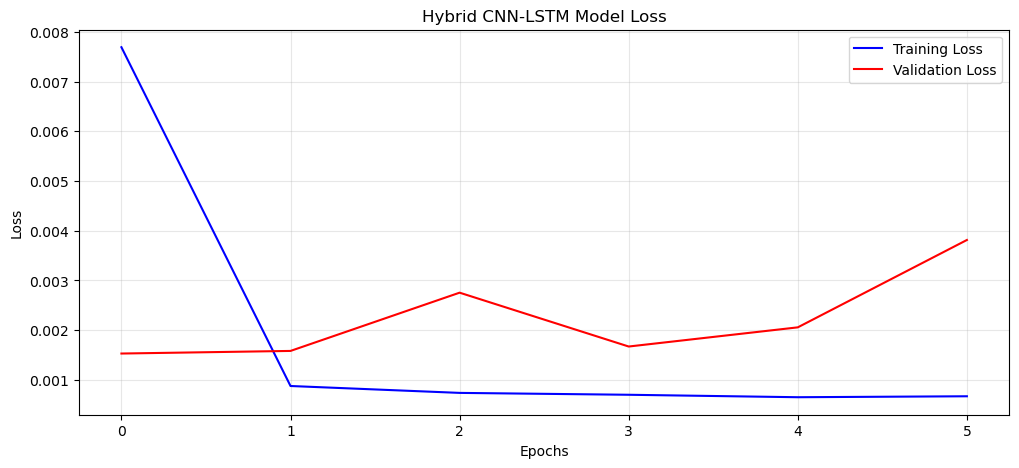

In [38]:
# Plot training history
plt.figure(figsize=(12,5))
plt.plot(history_hybrid.history['loss'], label='Training Loss', color='blue')
plt.plot(history_hybrid.history['val_loss'], label='Validation Loss', color='red')
plt.title('Hybrid CNN-LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [39]:
# Generate hybrid predictions
hybrid_predictions = hybrid_model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [40]:
# -------------------------- INVERSE TRANSFORM AND EVALUATE --------------------------
# Inverse transform predictions
lstm_predictions = scaler.inverse_transform(lstm_predictions)
cnn_predictions = scaler.inverse_transform(cnn_predictions)
hybrid_predictions = scaler.inverse_transform(hybrid_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [41]:
# Calculate RMSE, MAE, R² Score
# LSTM
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_predictions))
lstm_mae = mean_absolute_error(y_test_actual, lstm_predictions)
lstm_r2 = r2_score(y_test_actual, lstm_predictions)

In [42]:
# CNN
cnn_rmse = np.sqrt(mean_squared_error(y_test_actual, cnn_predictions))
cnn_mae = mean_absolute_error(y_test_actual, cnn_predictions)
cnn_r2 = r2_score(y_test_actual, cnn_predictions)

In [43]:
# Hybrid CNN-LSTM
hybrid_rmse = np.sqrt(mean_squared_error(y_test_actual, hybrid_predictions))
hybrid_mae = mean_absolute_error(y_test_actual, hybrid_predictions)
hybrid_r2 = r2_score(y_test_actual, hybrid_predictions)

In [44]:
# Calculate directional accuracy and precision
lstm_acc, lstm_prec = calculate_metrics(y_test_actual.flatten(), lstm_predictions.flatten())
cnn_acc, cnn_prec = calculate_metrics(y_test_actual.flatten(), cnn_predictions.flatten())
hybrid_acc, hybrid_prec = calculate_metrics(y_test_actual.flatten(), hybrid_predictions.flatten())

In [45]:
# Display results
print("\n----- LSTM Model Performance -----")
print(f"RMSE: {lstm_rmse:.4f}")
print(f"MAE: {lstm_mae:.4f}")
print(f"R² Score: {lstm_r2:.4f}")
print(f"Directional Accuracy: {lstm_acc:.4f}")
print(f"Directional Precision: {lstm_prec:.4f}")


----- LSTM Model Performance -----
RMSE: 6.3909
MAE: 5.2721
R² Score: 0.9584
Directional Accuracy: 0.4959
Directional Precision: 0.5217


In [46]:
print("\n----- CNN Model Performance -----")
print(f"RMSE: {cnn_rmse:.4f}")
print(f"MAE: {cnn_mae:.4f}")
print(f"R² Score: {cnn_r2:.4f}")
print(f"Directional Accuracy: {cnn_acc:.4f}")
print(f"Directional Precision: {cnn_prec:.4f}")


----- CNN Model Performance -----
RMSE: 8.5088
MAE: 7.0529
R² Score: 0.9262
Directional Accuracy: 0.5190
Directional Precision: 0.5439


In [47]:
print("\n----- Hybrid CNN-LSTM Model Performance -----")
print(f"RMSE: {hybrid_rmse:.4f}")
print(f"MAE: {hybrid_mae:.4f}")
print(f"R² Score: {hybrid_r2:.4f}")
print(f"Directional Accuracy: {hybrid_acc:.4f}")
print(f"Directional Precision: {hybrid_prec:.4f}")


----- Hybrid CNN-LSTM Model Performance -----
RMSE: 9.7316
MAE: 8.0999
R² Score: 0.9035
Directional Accuracy: 0.4837
Directional Precision: 0.5111


In [48]:
# Create a dataframe with all metrics for easy comparison
metrics_df = pd.DataFrame({
    'Model': ['LSTM', 'CNN', 'Hybrid CNN-LSTM'],
    'RMSE': [lstm_rmse, cnn_rmse, hybrid_rmse],
    'MAE': [lstm_mae, cnn_mae, hybrid_mae],
    'R²': [lstm_r2, cnn_r2, hybrid_r2],
    'Accuracy': [lstm_acc, cnn_acc, hybrid_acc],
    'Precision': [lstm_prec, cnn_prec, hybrid_prec]
})

In [49]:
# Display comparison table
print("\n----- Models Comparison -----")
print(metrics_df.to_string(index=False))


----- Models Comparison -----
          Model     RMSE      MAE       R²  Accuracy  Precision
           LSTM 6.390853 5.272119 0.958380  0.495924   0.521739
            CNN 8.508809 7.052888 0.926222  0.519022   0.543902
Hybrid CNN-LSTM 9.731629 8.099937 0.903493  0.483696   0.511062


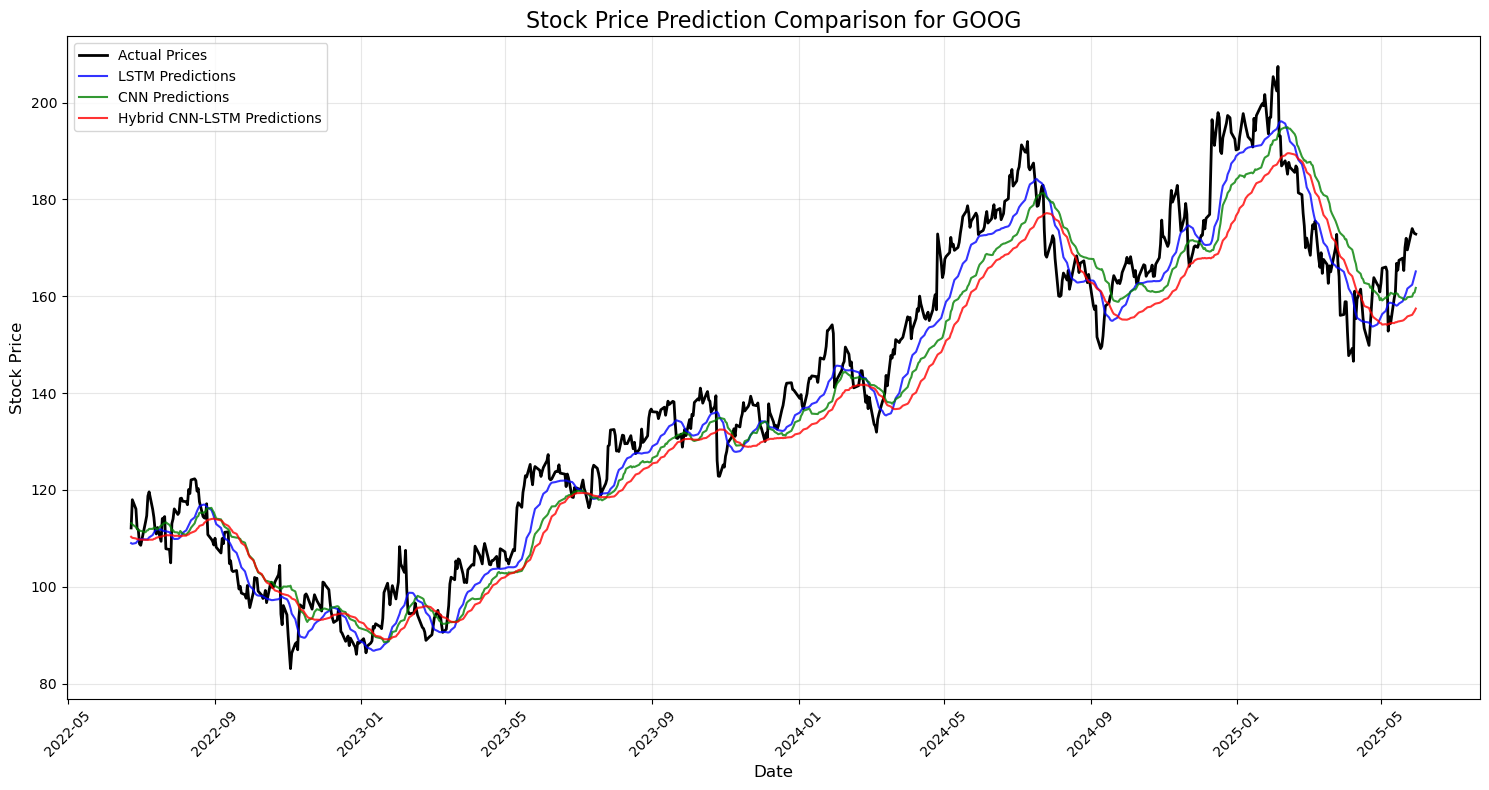

In [50]:
# -------------------------- VISUALIZE RESULTS --------------------------
# Plot predictions vs actual
plt.figure(figsize=(15,8))
plt.plot(test_dates, y_test_actual, label='Actual Prices', color='black', linewidth=2)
plt.plot(test_dates, lstm_predictions, label='LSTM Predictions', color='blue', alpha=0.8)
plt.plot(test_dates, cnn_predictions, label='CNN Predictions', color='green', alpha=0.8)
plt.plot(test_dates, hybrid_predictions, label='Hybrid CNN-LSTM Predictions', color='red', alpha=0.8)
plt.title(f'Stock Price Prediction Comparison for {stock}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [51]:
# Plot individual model predictions for better visibility
models = {
    'LSTM': lstm_predictions,
    'CNN': cnn_predictions,
    'Hybrid CNN-LSTM': hybrid_predictions
}
colors = {
    'LSTM': 'blue',
    'CNN': 'green',
    'Hybrid CNN-LSTM': 'red'
}

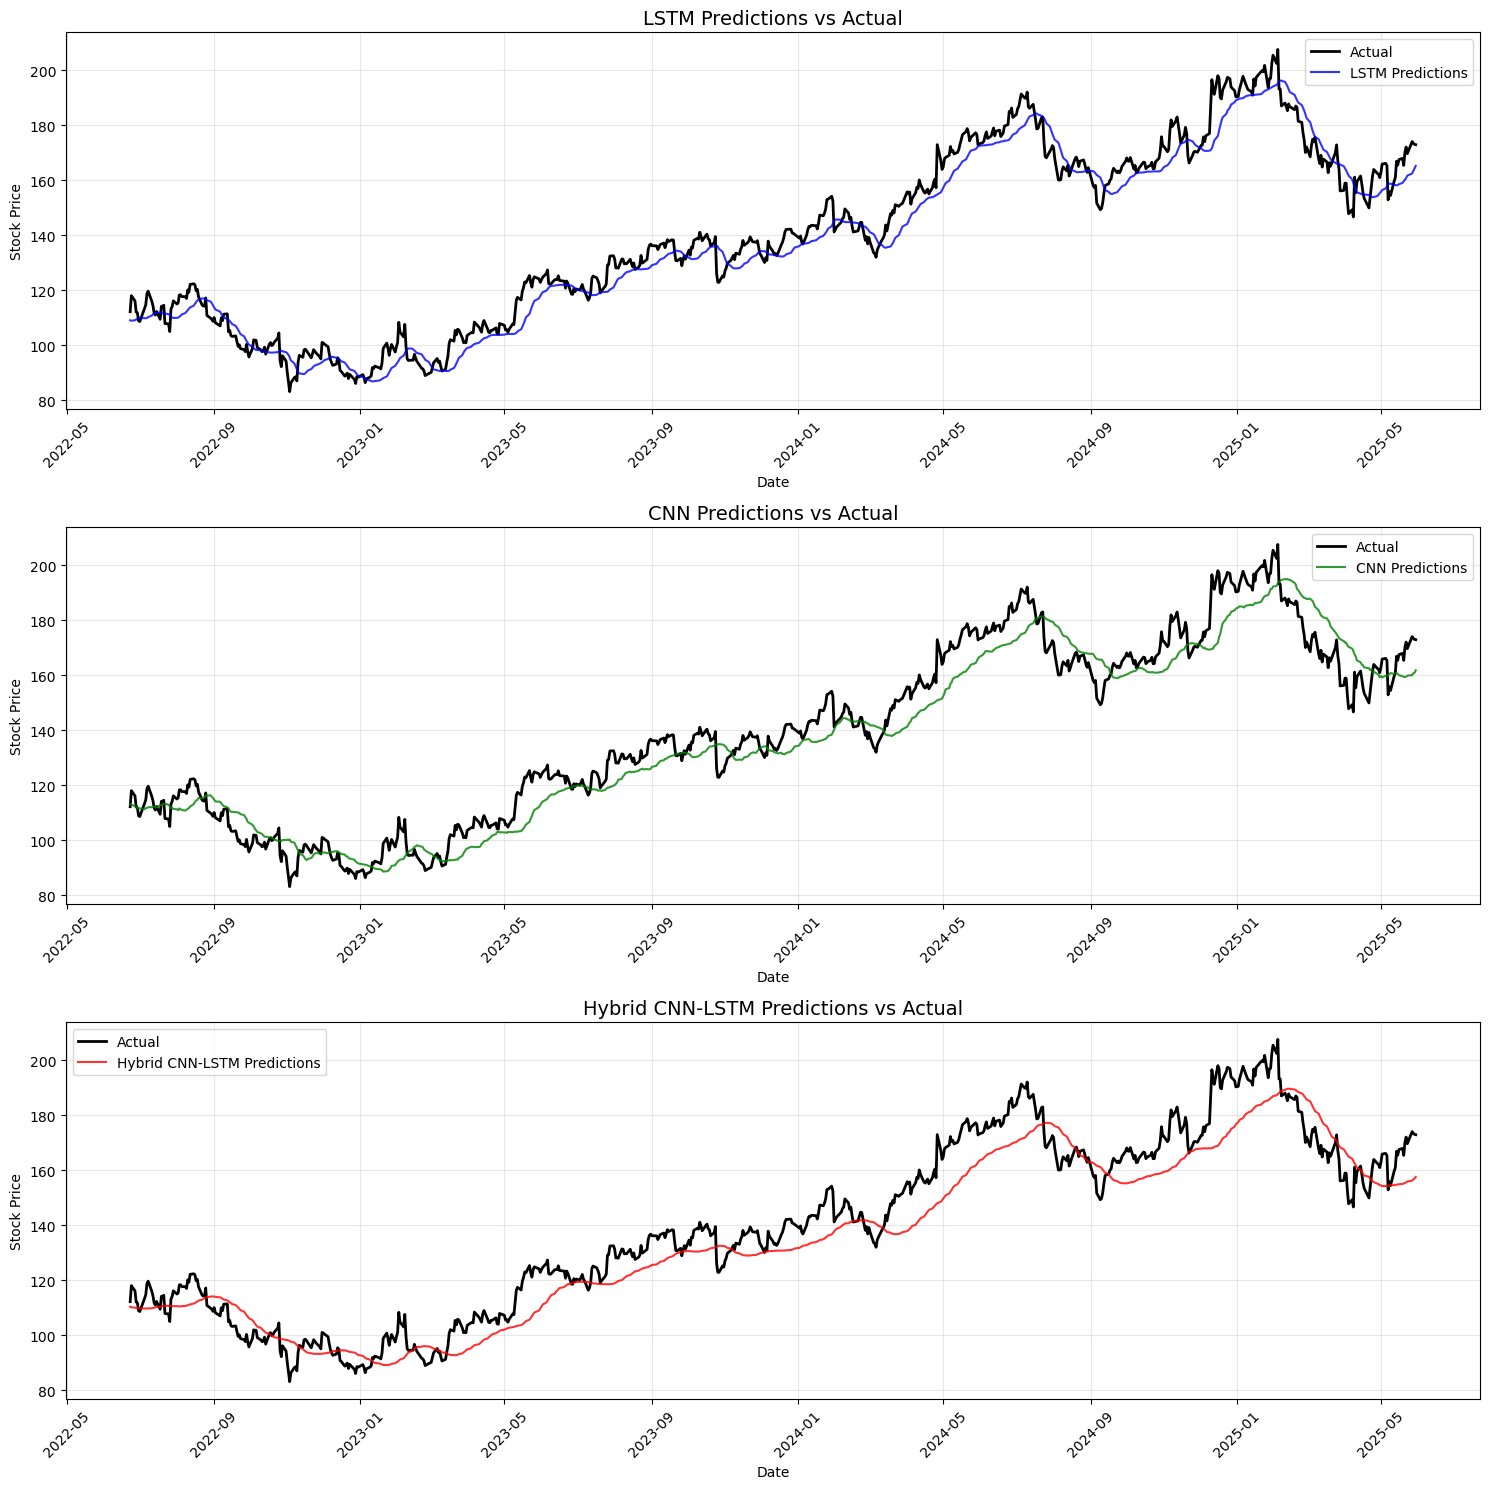

In [52]:
# Plot individual model predictions for better visibility
plt.figure(figsize=(15, 15))
for i, (model_name, predictions) in enumerate(models.items(), 1):
    plt.subplot(3, 1, i)
    plt.plot(test_dates, y_test_actual, label='Actual', color='black', linewidth=2)
    plt.plot(test_dates, predictions, label=f'{model_name} Predictions', 
             color=colors[model_name], alpha=0.8)
    plt.title(f'{model_name} Predictions vs Actual', fontsize=14)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Stock Price', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

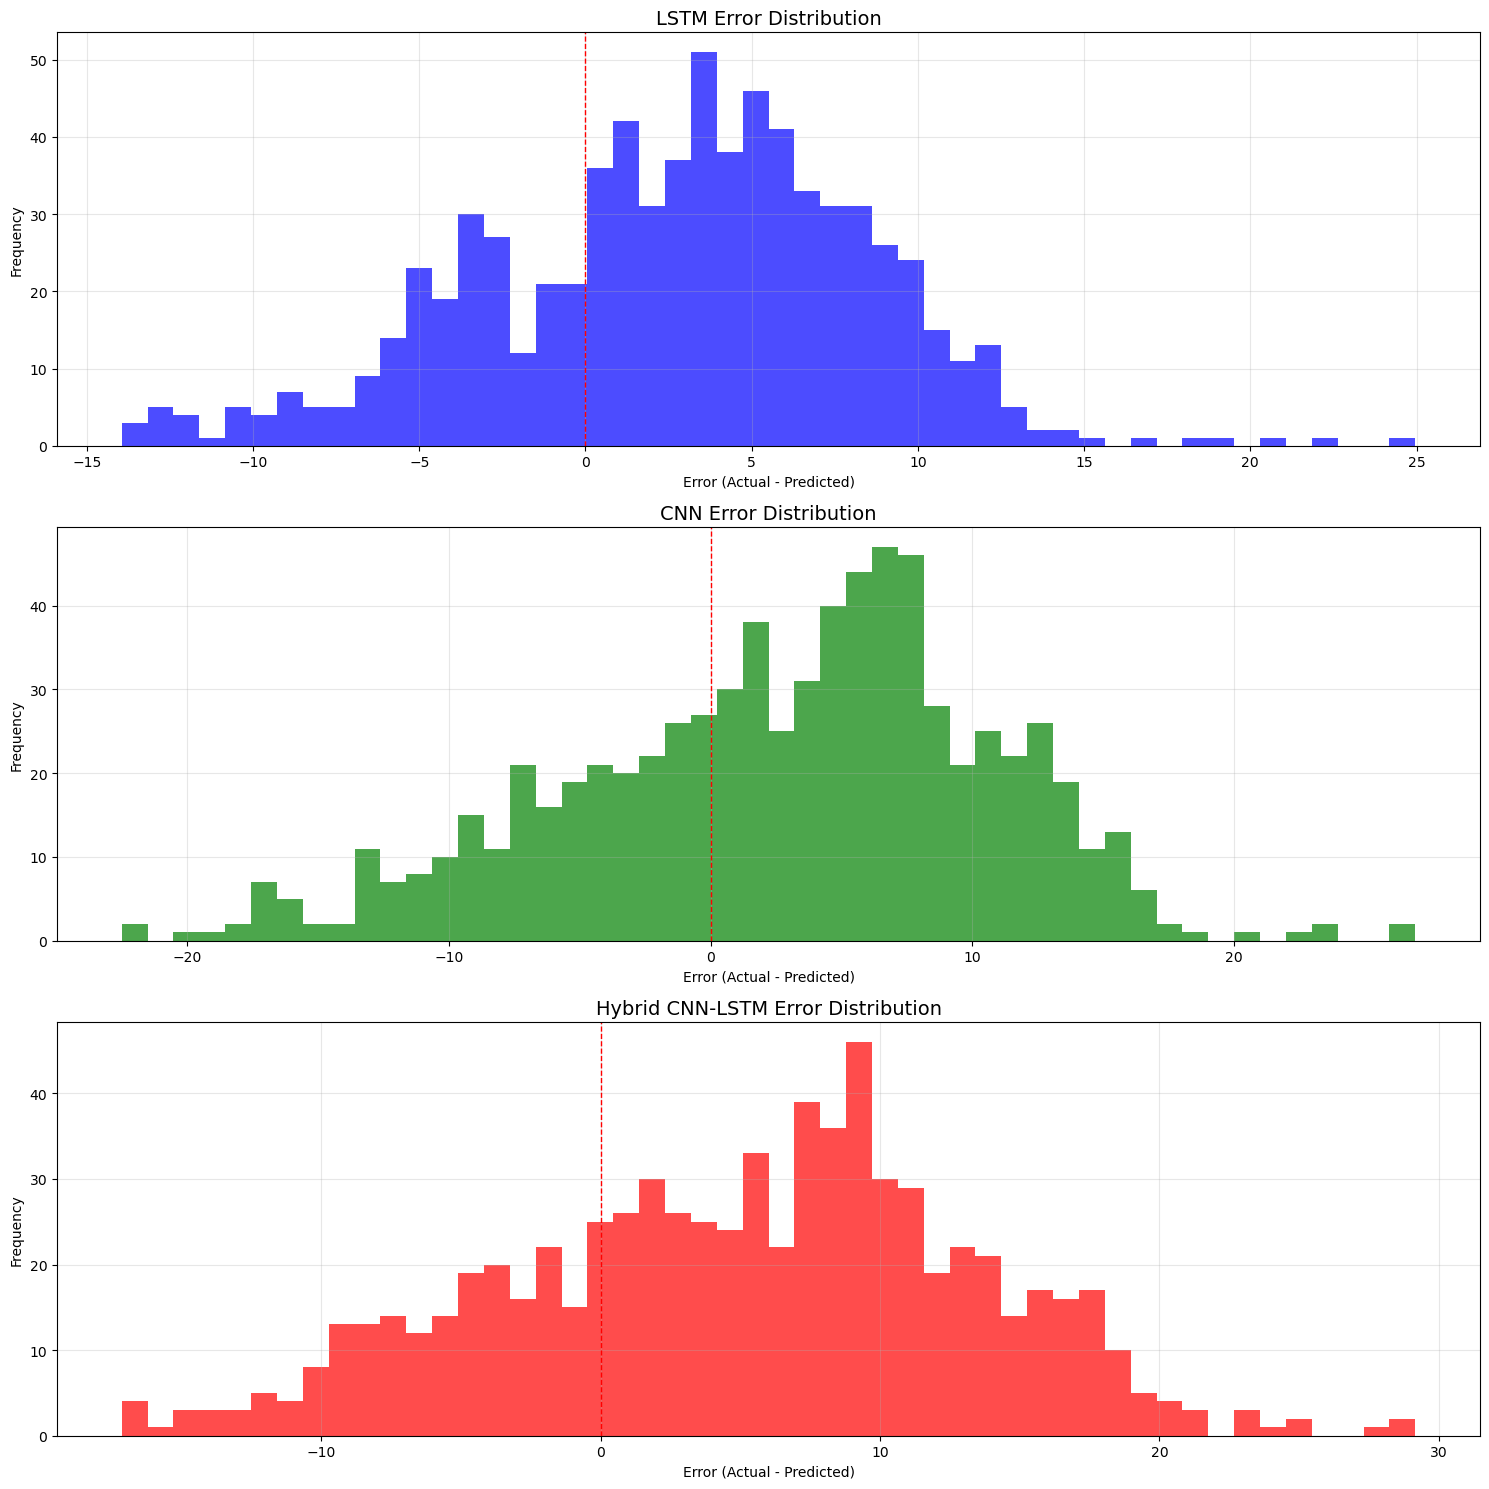

In [53]:
# Plot error distribution
plt.figure(figsize=(15, 15))
for i, (model_name, predictions) in enumerate(models.items(), 1):
    errors = y_test_actual.flatten() - predictions.flatten()
    plt.subplot(3, 1, i)
    plt.hist(errors, bins=50, alpha=0.7, color=colors[model_name])
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
    plt.title(f'{model_name} Error Distribution', fontsize=14)
    plt.xlabel('Error (Actual - Predicted)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

In [54]:
# -------------------------- FUTURE PREDICTIONS --------------------------
# Make future predictions using the best model
# Determine the best model based on RMSE
best_model_name = metrics_df.loc[metrics_df['RMSE'].idxmin(), 'Model']
print(f"\nThe best performing model based on RMSE is: {best_model_name}")


The best performing model based on RMSE is: LSTM


In [55]:
# Prepare data for future predictions
# Get the most recent data points
future_days = 30  # Number of days to predict
last_sequence = scaled_data[-lookback:].reshape(1, lookback, 1)

In [56]:
# Make predictions based on best model
if best_model_name == 'LSTM':
    best_model = lstm_model
elif best_model_name == 'CNN':
    best_model = cnn_model
else:  # Hybrid CNN-LSTM
    best_model = hybrid_model

In [57]:
# Generate future predictions
future_predictions = []
current_sequence = last_sequence.copy()

In [58]:
for _ in range(future_days):
    # Get prediction for next day
    pred = best_model.predict(current_sequence)
    # Add prediction to list
    future_predictions.append(pred[0,0])
    # Update sequence by removing oldest value and adding the prediction
    # Reshape the prediction to match the expected dimensions (1, 1, 1)
    pred_reshaped = np.array([[[pred[0,0]]]])
    current_sequence = np.append(current_sequence[:,1:,:], pred_reshaped, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

In [59]:
# Inverse transform the predictions
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions)

In [60]:
# Generate future dates
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)

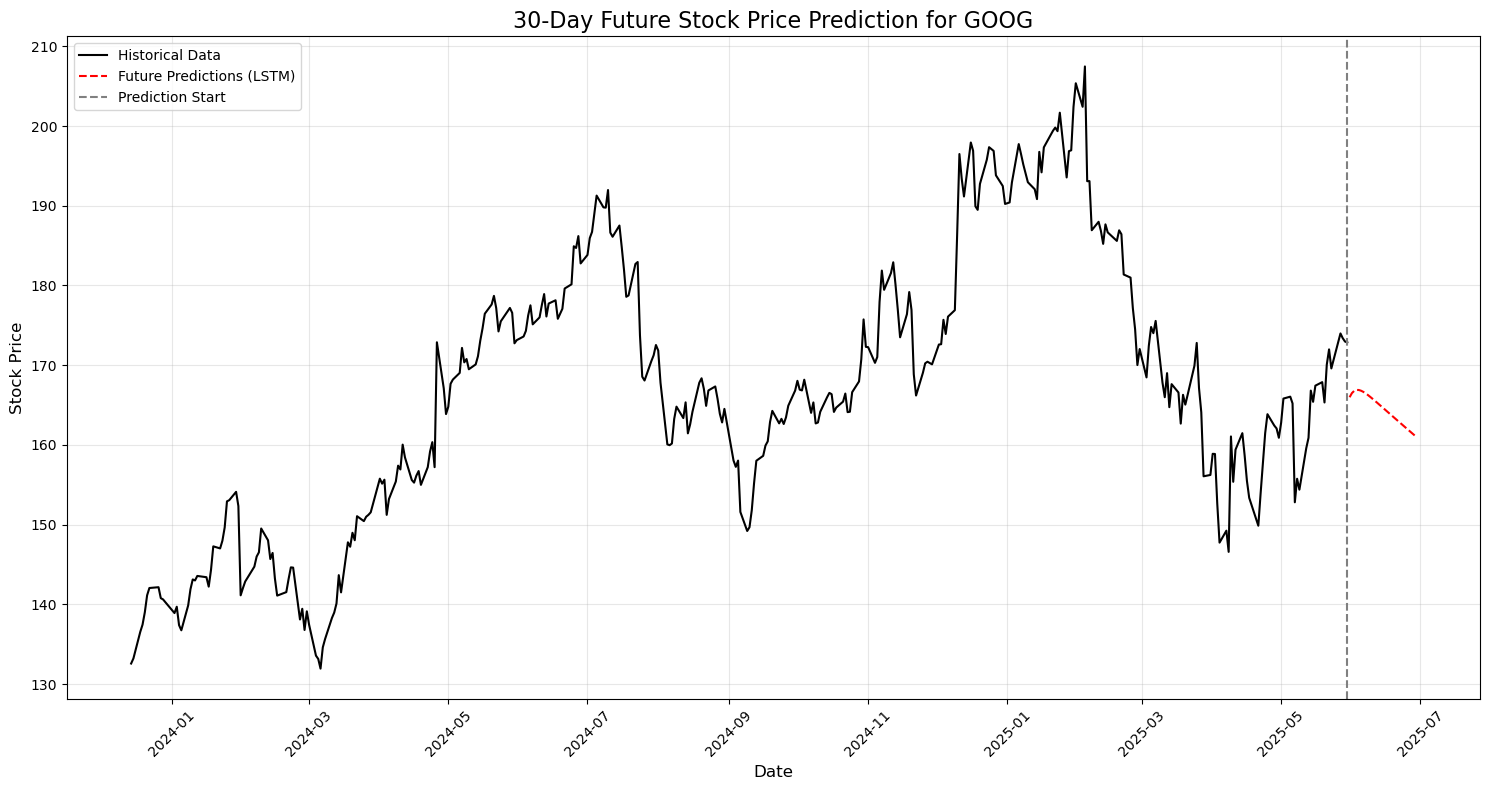

In [61]:
# Plot historical and future predictions
plt.figure(figsize=(15, 8))

# Plot historical data
plt.plot(data.index[-365:], data['Close'].values[-365:], label='Historical Data', color='black')

# Plot future predictions
plt.plot(future_dates, future_predictions, label=f'Future Predictions ({best_model_name})', 
         color='red', linestyle='--')
plt.axvline(x=last_date, color='gray', linestyle='--', label='Prediction Start')
plt.title(f'{future_days}-Day Future Stock Price Prediction for {stock}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [62]:
# Create a DataFrame with future predictions
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_predictions.flatten()
})

In [63]:
print("\nFuture Price Predictions:")
print(future_df)


Future Price Predictions:
         Date  Predicted_Price
0  2025-05-31       165.976730
1  2025-06-01       166.489426
2  2025-06-02       166.774078
3  2025-06-03       166.890305
4  2025-06-04       166.886536
5  2025-06-05       166.798828
6  2025-06-06       166.653427
7  2025-06-07       166.469223
8  2025-06-08       166.259415
9  2025-06-09       166.032944
10 2025-06-10       165.796051
11 2025-06-11       165.552719
12 2025-06-12       165.305557
13 2025-06-13       165.056305
14 2025-06-14       164.805923
15 2025-06-15       164.555069
16 2025-06-16       164.304092
17 2025-06-17       164.053192
18 2025-06-18       163.802521
19 2025-06-19       163.552094
20 2025-06-20       163.301956
21 2025-06-21       163.052109
22 2025-06-22       162.802597
23 2025-06-23       162.553345
24 2025-06-24       162.304443
25 2025-06-25       162.055801
26 2025-06-26       161.807495
27 2025-06-27       161.559464
28 2025-06-28       161.311768
29 2025-06-29       161.064377


In [64]:
# -------------------------- CONCLUSION --------------------------
# Find the best model for each metric
best_rmse = metrics_df.loc[metrics_df['RMSE'].idxmin(), 'Model']
best_mae = metrics_df.loc[metrics_df['MAE'].idxmin(), 'Model']
best_r2 = metrics_df.loc[metrics_df['R²'].idxmax(), 'Model']
best_acc = metrics_df.loc[metrics_df['Accuracy'].idxmax(), 'Model']
best_prec = metrics_df.loc[metrics_df['Precision'].idxmax(), 'Model']

In [65]:
print("\n----- Best Model by Metric -----")
print(f"RMSE (lower is better): {best_rmse}")
print(f"MAE (lower is better): {best_mae}")
print(f"R² (higher is better): {best_r2}")
print(f"Directional Accuracy (higher is better): {best_acc}")
print(f"Directional Precision (higher is better): {best_prec}")


----- Best Model by Metric -----
RMSE (lower is better): LSTM
MAE (lower is better): LSTM
R² (higher is better): LSTM
Directional Accuracy (higher is better): CNN
Directional Precision (higher is better): CNN


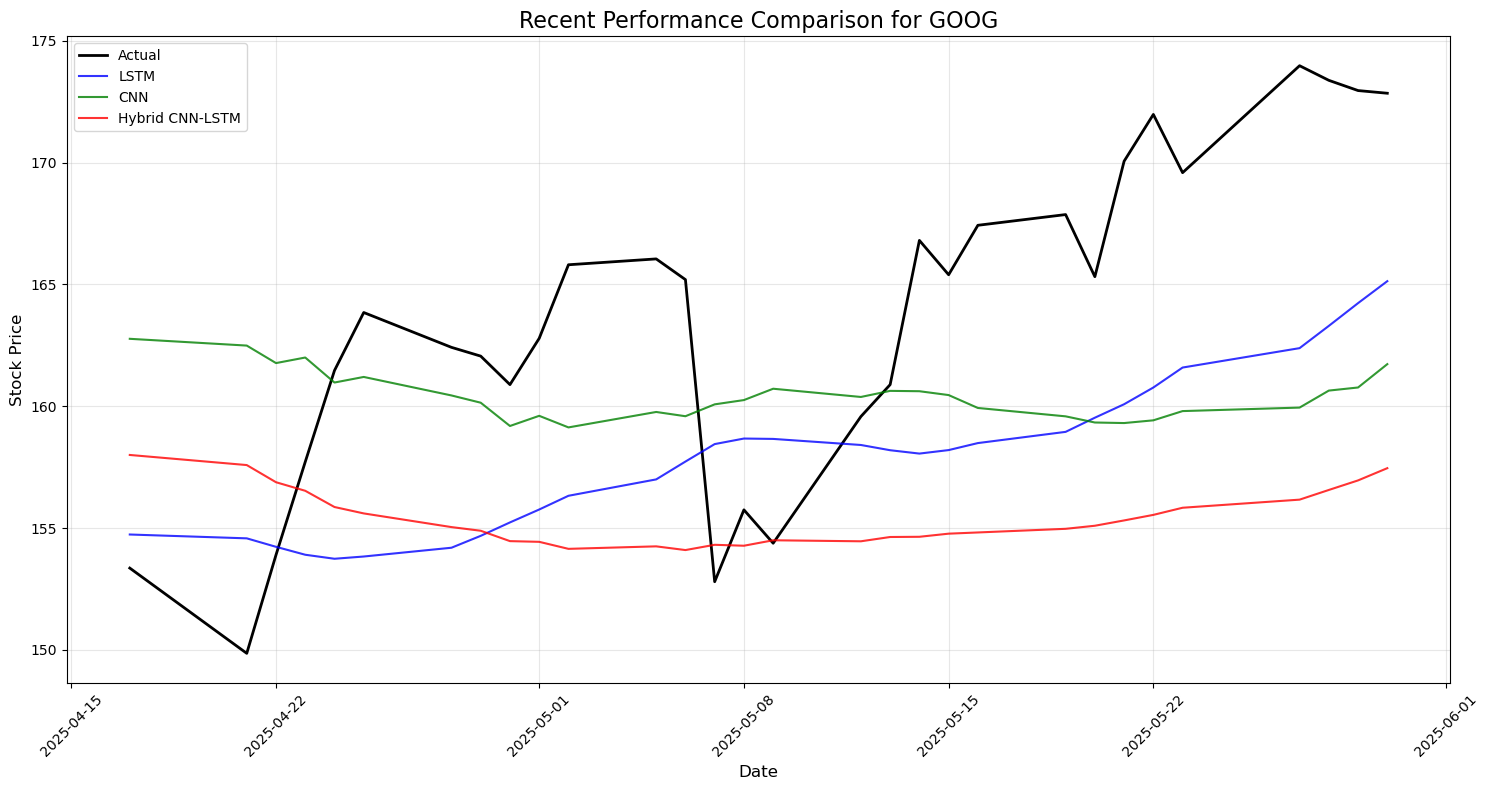

In [66]:
# Calculate feature importance for the test predictions (approximation)
last_n_days = min(30, len(test_dates))  # Use most recent month of data or whatever is available
if last_n_days > 0:
    recent_actual = y_test_actual[-last_n_days:].flatten()
    recent_dates = test_dates[-last_n_days:]
    recent_predictions = {
        'LSTM': lstm_predictions[-last_n_days:].flatten(),
        'CNN': cnn_predictions[-last_n_days:].flatten(),
        'Hybrid CNN-LSTM': hybrid_predictions[-last_n_days:].flatten()
    }
    # Plot recent performance
    plt.figure(figsize=(15, 8))
    plt.plot(recent_dates, recent_actual, label='Actual', color='black', linewidth=2)
    for model_name, preds in recent_predictions.items():
        if preds is not None:
            plt.plot(recent_dates, preds, label=f'{model_name}', color=colors.get(model_name, 'gray'), alpha=0.8)
    
    plt.title(f'Recent Performance Comparison for {stock}', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Stock Price', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [67]:
print(f"\nStock Price Prediction Analysis for {stock} Complete!")
print("Remember that these predictions are estimates based on historical patterns.")
print("Always consider fundamental analysis and market conditions before making investment decisions.")


Stock Price Prediction Analysis for GOOG Complete!
Remember that these predictions are estimates based on historical patterns.
Always consider fundamental analysis and market conditions before making investment decisions.
